In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import nltk
nltk.download('punkt')  # download full punkt tokenizer


[nltk_data] Downloading package punkt to /home/sarthak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load Dataset

In [29]:
train_path = "/home/sarthak/Genre_Classification_Dataset/train_data.txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')


In [30]:
train_data.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [32]:
train_data.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

### Load the test data

In [33]:
test_path = "/home/sarthak/Genre_Classification_Dataset/test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_data.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [34]:
test_data

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...
...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da..."
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard..."


### EDA & Visualization

/tmp/ipykernel_7504/2395457256.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette='viridis')
/tmp/ipykernel_7504/2395457256.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts, palette='viridis')


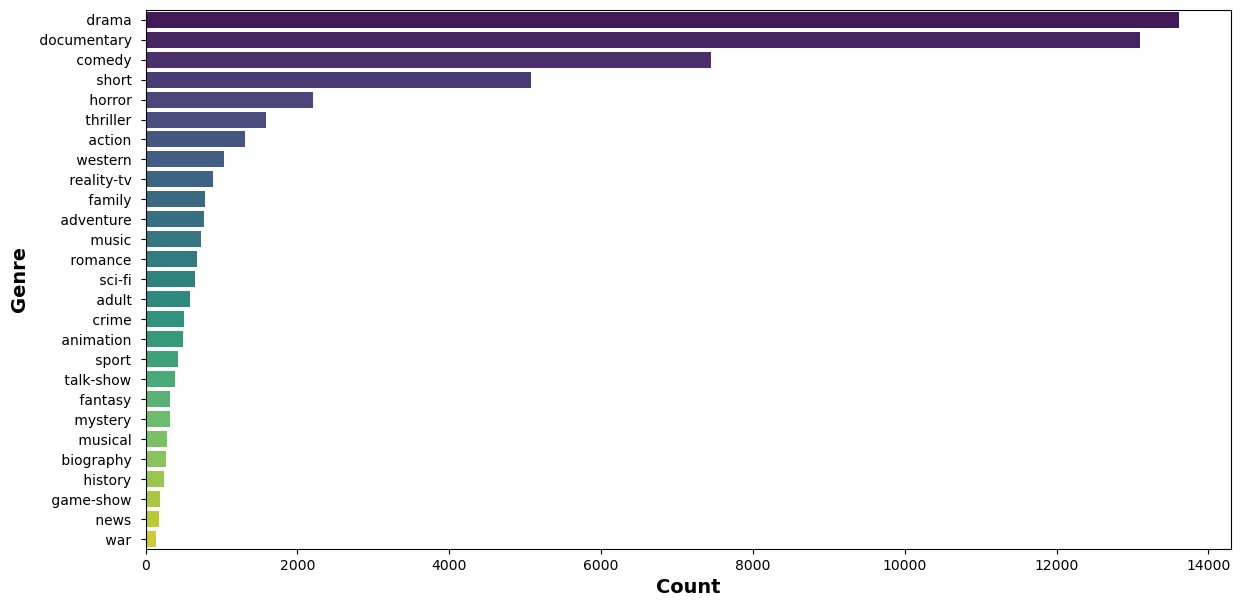

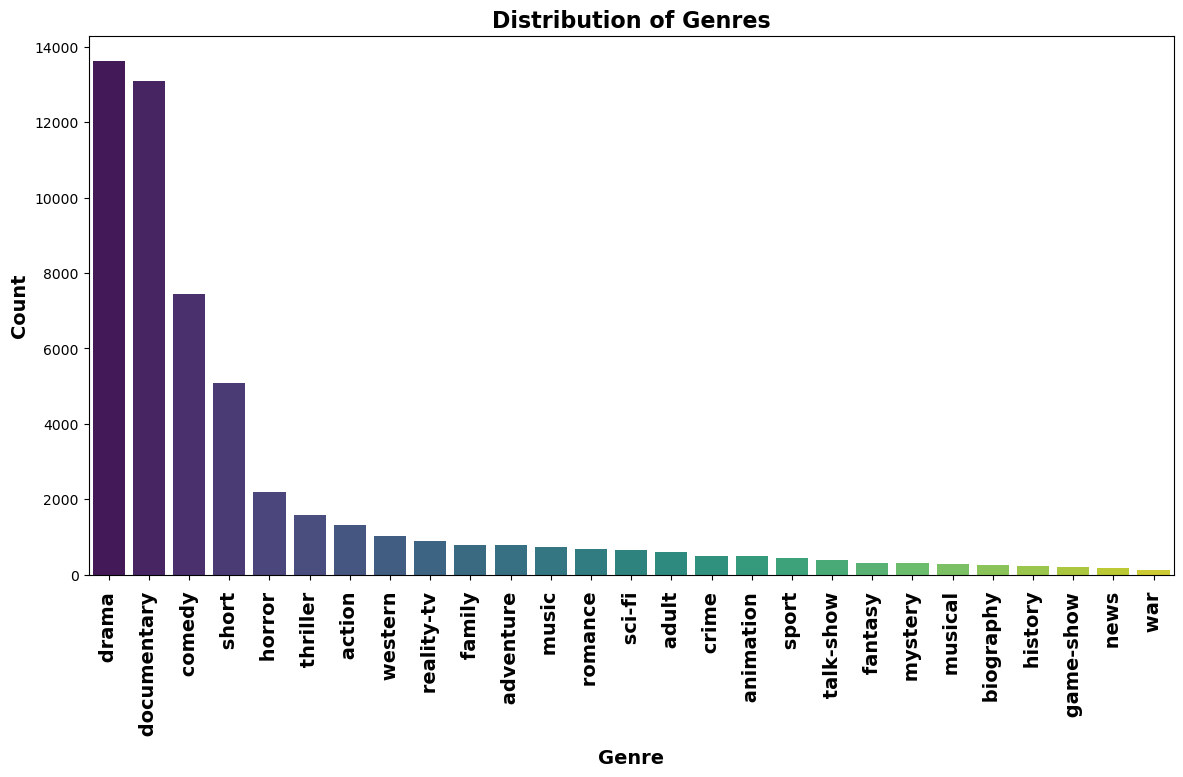

In [35]:
plt.figure(figsize=(14, 7))
sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')

plt.figure(figsize=(14, 7))
counts = train_data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='viridis')
plt.xlabel('Genre', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()

### Data Preprocessing and Text Cleaning

In [46]:
import re
import string

basic_stopwords = {
    'the', 'and', 'is', 'in', 'to', 'of', 'for', 'a', 'an', 'this', 'that',
    'on', 'it', 'with', 'as', 'by', 'are', 'was', 'from', 'at', 'be', 'or',
    'has', 'have', 'but', 'not', 'will', 'its', 'they', 'you', 'we'
}

def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z']", ' ', text)  # Keep letters and apostrophes
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = text.split()  # Tokenize using simple split
    words = [w for w in words if w not in basic_stopwords and len(w) > 2]

    return ' '.join(words)


In [50]:
print(train_data.columns)
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)


Index(['Title', 'Genre', 'Description'], dtype='object')


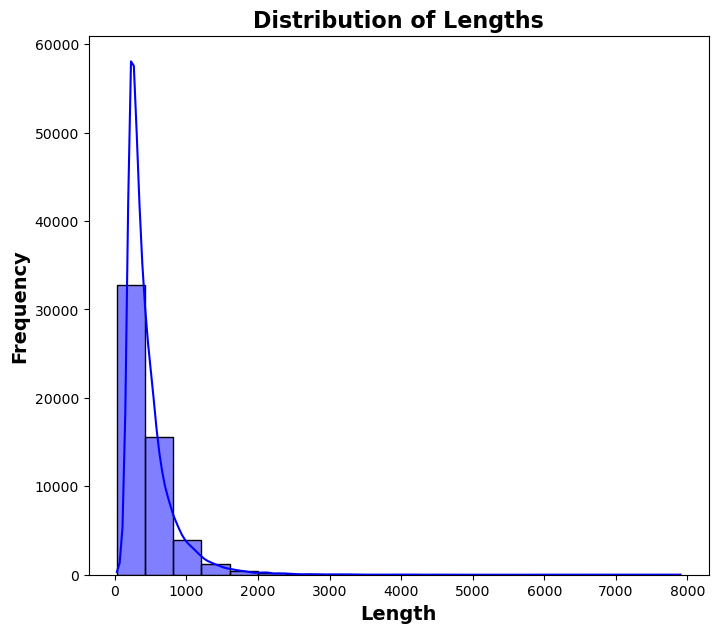

In [51]:
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()


In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(train_data['Text_cleaning'])

X_test_tfidf = tfidf.transform(test_data['Description'].apply(clean_text))


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

X = X_train_tfidf
y = train_data['Genre']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Validation Accuracy: 0.5193212210642811

Classification Report:
                precision    recall  f1-score   support

      action        0.58      0.08      0.15       263
       adult        0.80      0.04      0.07       112
   adventure        0.40      0.03      0.05       139
   animation        0.00      0.00      0.00       104
   biography        0.00      0.00      0.00        61
      comedy        0.51      0.42      0.46      1443
       crime        0.00      0.00      0.00       107
 documentary        0.57      0.89      0.70      2659
       drama        0.45      0.83      0.59      2697
      family        1.00      0.01      0.01       150
     fantasy        0.00      0.00      0.00        74
   game-show        1.00      0.10      0.18        40
     history        0.00      0.00      0.00        45
      horror        0.73      0.32      0.45       431
       music        0.84      0.11      0.20       144
     musical        0.00      0.00      0.00        50

/home/sarthak/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sarthak/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sarthak/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
test_preds = model.predict(X_test_tfidf)

test_data['Predicted_Genre'] = test_preds

print(test_data[['Title', 'Predicted_Genre']].head())


                           Title Predicted_Genre
0          Edgar's Lunch (1998)           drama 
1      La guerra de papá (1977)           drama 
2   Off the Beaten Track (2010)     documentary 
3        Meu Amigo Hindu (2015)           drama 
4             Er nu zhai (1955)           drama 


In [56]:
test_data[['Title', 'Predicted_Genre']].to_csv('test_predictions.csv', index=False)
